In [72]:
import matplotlib.pyplot as plt
import seaborn as sns 
import pandas as pd 
import numpy as np 

# Data Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PowerTransformer
from sklearn.metrics import mean_squared_error
from sklearn.impute import SimpleImputer
import re 

# Modeling and evaluation 
from sklearn.ensemble import (
    BaggingClassifier,
    ExtraTreesClassifier,
    RandomForestClassifier,
    StackingClassifier,
    HistGradientBoostingClassifier
)

In [73]:
from sklearn.metrics import classification_report 
# import joblib # 파이프제작 파이프라인

# Packages options 
sns.set(rc={'figure.figsize': [14, 7]}, font_scale=1.2) # Standard figure size for all 
np.seterr(divide='ignore', invalid='ignore', over='ignore') 

import warnings 
warnings.filterwarnings("ignore")

In [74]:
df = pd.read_csv('./csv/test_swmotorcycle_False.csv')


In [75]:
# 범주형 데이터를 get_dummies 함수로 Onehot_인코딩 방법처럼 생성

dfd =df[['Gender','Area']]
dfd_dummies = pd.get_dummies(dfd)
df1 = df.drop(['Gender','Area'], axis='columns')
df2 = pd.concat([dfd_dummies,df1],axis=1)

In [76]:
# Risk 변수 생성
# 기존 claimNb는 그대로 놓고 claimNb이진분류한것 생성
# Risk 는 기존 climNb로 나누기
# Nb와 Amount를 더함(새로운 컬럼 생성), amount 와 새로운 컬럼 데이터 프레임으로 만든후 조건식 만들기
# target 변수 2진분류로 전환
df2['ClaimNb1'] = df2['ClaimNb']
df2["Risk"]=df2["ClaimNb"]/np.round(df2["Exposure"], 2)
# df2 =df2.drop(columns='ClaimAmount')
df2['ClaimNb1'].replace(2,1,inplace=True)



In [77]:
# 문자열을 숫자열로 바꾸기 (연속형데이터로 만들기) 

m2 = {
    "BM1" : 1,
    "BM2" : 2,
    "BM3" : 3,
    "BM4" : 4,
    "BM5" : 5,
    "BM6" : 6,
    "BM7" : 7
}

df2['BonusClass1'] = df2['BonusClass'].map(m2)

m3 = {
    "EV ratio 9-12": 3,
    "EV ratio 13-15": 4,
    "EV ratio 16-19": 5,
    "EV ratio 20-24" : 6,
    "EV ratio <5" : 1,
    "EV ratio 6-8" : 2,
    "EV ratio >25" : 7
}

df2['RiskClass1'] = df2['RiskClass'].map(m3)

In [78]:
# 이상치 제거 , 밑에 박스플롯 돌리면서 하기 
# import numpy as np
# for i in range(len(df2["OwnerAge"])):
#     if df2["OwnerAge"][i] >= 75 :
#         df2["OwnerAge"][i] = np.nan
#     elif df2["OwnerAge"][i] < 16 :
#         df2["OwnerAge"][i] = np.nan
#     else:
#         pass

# for i in range(len(df2["VehAge"])):
#     if df2["VehAge"][i] >= 35:
#         df2["VehAge"][i] = np.nan
#     else:
#         pass
# for i in range(len(df2["Risk"])):
#     if df2["Risk"][i] >= 80:
#         df2["Risk"][i] = np.nan
#     else:
#         pass

In [79]:
df2.drop(columns='ClaimNb', inplace=True)
df2 = df2.replace([np.inf, -np.inf], np.nan)

In [80]:
df2.dropna(axis=0,inplace=True)

In [81]:
df2.columns.value_counts()

Gender_Female                                                   1
RiskClass                                                       1
BonusClass1                                                     1
Risk                                                            1
ClaimNb1                                                        1
ClaimAmount                                                     1
Exposure                                                        1
BonusClass                                                      1
VehAge                                                          1
OwnerAge                                                        1
Gender_Male                                                     1
Area_Suburbs; middle-sized cities                               1
Area_Small towns; countryside except Gotland; Northern towns    1
Area_Northern towns                                             1
Area_Northern countryside                                       1
Area_Lesse

In [82]:
df2['Central']=df2["Area_Central parts of Sweden's three largest cities"]
df2['Gotland']=df2["Area_Gotland (Sweden's largest island)"]
df2['Lesser']=df2["Area_Lesser towns except Gotland; Northern towns"] 
df2['Northern_countryside']=df2["Area_Northern countryside"] 
df2['Northern towns']=df2["Area_Northern towns"] 
df2['Small towns']=df2["Area_Small towns; countryside except Gotland; Northern towns"] 
df2['Suburbs']=df2["Area_Suburbs; middle-sized cities"] 

In [83]:
df2 = df2.drop(columns=["Area_Central parts of Sweden's three largest cities","Area_Gotland (Sweden's largest island)","Area_Lesser towns except Gotland; Northern towns","Area_Northern countryside","Area_Northern towns","Area_Small towns; countryside except Gotland; Northern towns","Area_Suburbs; middle-sized cities"] )

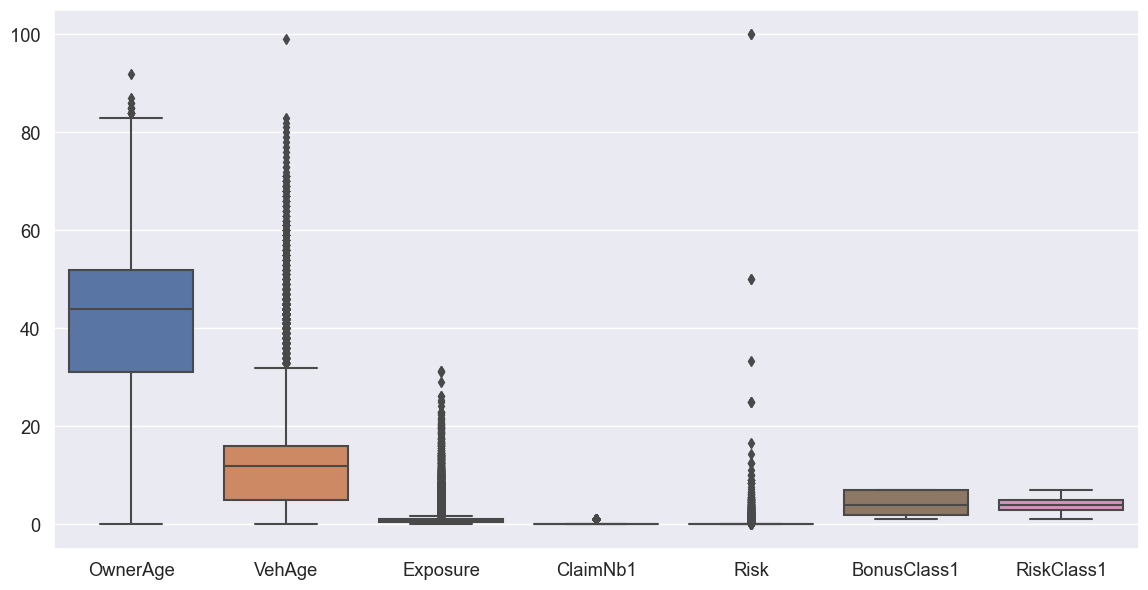

In [84]:
# 박스플롯 보기 (이상치 확인)
sns.boxplot(df2[['OwnerAge','VehAge','Exposure','ClaimNb1','Risk','BonusClass1','RiskClass1']])
plt.show()

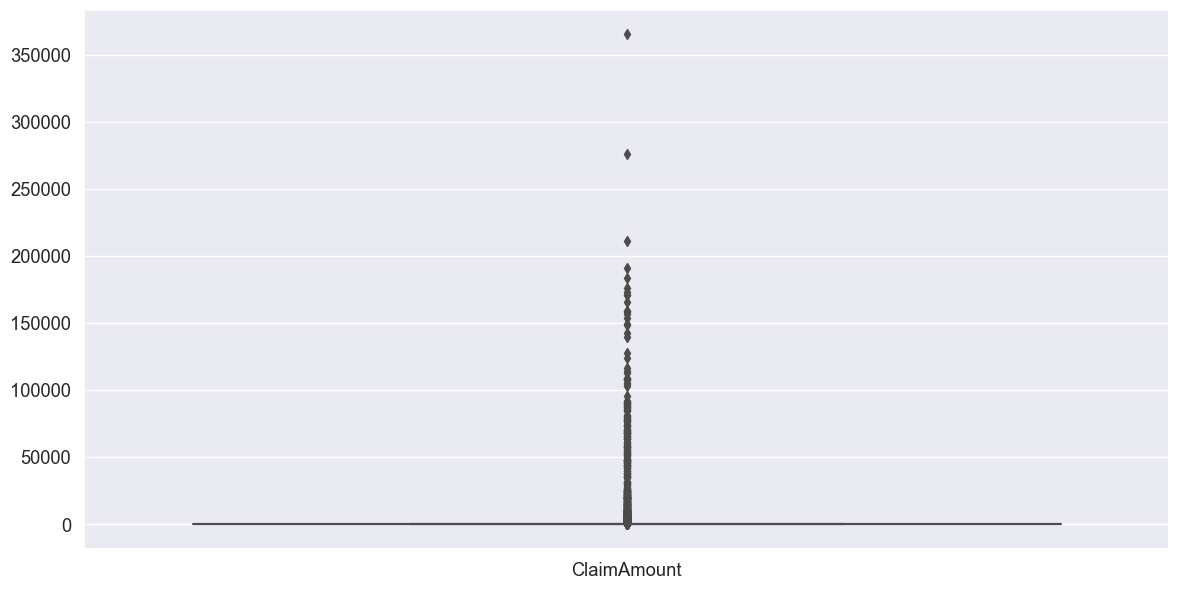

In [85]:
sns.boxplot(df2[['ClaimAmount']])
plt.show()

<AxesSubplot: >

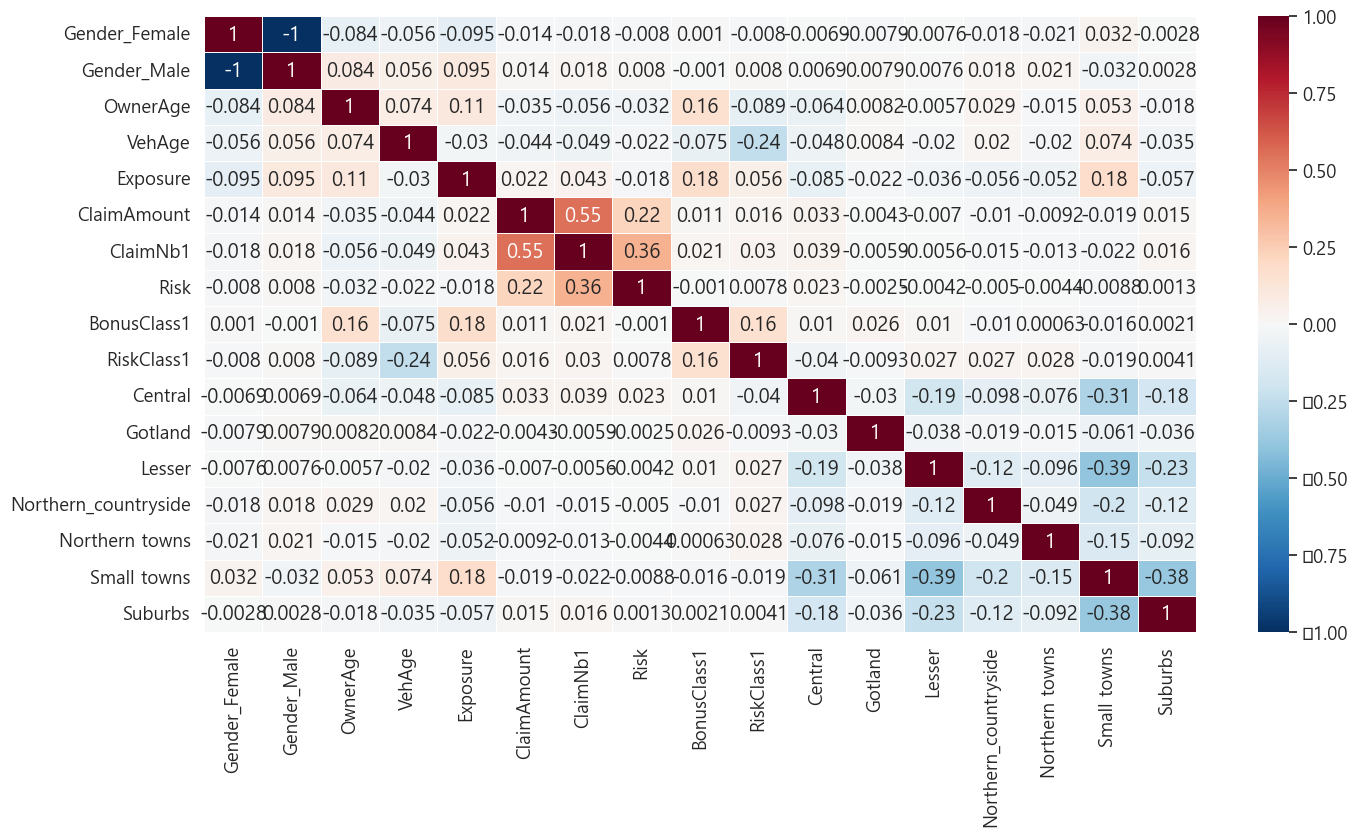

In [86]:
# 변수간 상관계수 파악
import matplotlib.pyplot as plt
import seaborn as sns
plt.rc('font', family='Malgun Gothic')

df_att = df2.corr(method='pearson')
plt.figure(figsize=(16,8))
sns.heatmap(df_att,
           xticklabels = df_att.columns,
           yticklabels = df_att.columns,
           cmap='RdBu_r',
           annot=True, 
           linewidth=0.5,vmin=-1)

In [87]:
# sns.pairplot(df2[['OwnerAge','VehAge','Exposure','ClaimNb1','Risk','BonusClass1','RiskClass1','ClaimAmount']])
# plt.show()

In [88]:
# 다중공성선 확인
df2 = df2.drop(columns=["RiskClass","BonusClass"])
from statsmodels.stats.outliers_influence import variance_inflation_factor
feature = df2.drop(columns=["ClaimNb1","Gender_Female","Gender_Male","Central","Gotland", "Lesser",	"Northern_countryside","Northern towns","Small towns","Suburbs"])
labels = df2['ClaimNb1']

vif = pd.DataFrame(
    [variance_inflation_factor(feature.values, i) for i in range(feature.shape[1])],
    index=feature.columns, columns=['VIF'])
vif.sort_values(by='VIF', ascending=False)

,VIF
OwnerAge,6.954937
RiskClass1,4.852919
BonusClass1,4.166963
VehAge,2.464419
Exposure,1.697793
ClaimAmount,1.056025
Risk,1.052435


### 모델링 시작

In [89]:
#split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(feature, labels, test_size=0.2, random_state=0)

In [90]:
# train 값 MinMaxScaler
from sklearn.preprocessing import PowerTransformer, MinMaxScaler, StandardScaler

scalar = MinMaxScaler()
scalar_df = scalar.fit_transform(X_train)

df_scalar = pd.DataFrame(scalar_df)
df_scalar.describe()

,0,1,2,3,4,5,6
count,49895.000000,49895.000000,49895.000000,49895.000000,49895.000000,49895.000000,49895.000000
mean,0.431025,0.126832,0.033333,0.000746,0.000257,0.507923,0.449116
std,0.148797,0.097712,0.042382,0.013314,0.006497,0.394366,0.252320
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.298851,0.050505,0.015540,0.000000,0.000000,0.166667,0.333333
50%,0.448276,0.121212,0.028358,0.000000,0.000000,0.500000,0.500000
75%,0.540230,0.161616,0.031870,0.000000,0.000000,1.000000,0.666667
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [91]:
#test 값 MinMaxScaler
test_scaled = scalar.transform(X_test)
df1_scalar = pd.DataFrame(test_scaled)
df1_scalar.describe()

,0,1,2,3,4,5,6
count,12474.000000,12474.000000,12474.000000,12474.000000,12474.00000,12474.000000,12474.000000
mean,0.433906,0.127056,0.033387,0.000733,0.00032,0.512546,0.448065
std,0.149560,0.098421,0.041341,0.011989,0.00987,0.394331,0.251756
min,-0.057471,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
25%,0.298851,0.050505,0.015628,0.000000,0.00000,0.166667,0.333333
50%,0.448276,0.121212,0.029148,0.000000,0.00000,0.500000,0.500000
75%,0.540230,0.171717,0.031870,0.000000,0.00000,1.000000,0.666667
max,0.931034,0.838384,1.004127,0.468875,1.00000,1.000000,1.000000


In [92]:
#언더샘플링
from sklearn.datasets import make_classification
from collections import Counter
from imblearn.under_sampling import RandomUnderSampler

undersample = RandomUnderSampler(sampling_strategy=1) 
X_under, y_under = undersample.fit_resample(X_train, y_train)
print(Counter(y_under))

Counter({0: 528, 1: 528})


In [93]:
#오버샘플링
from imblearn.over_sampling import SMOTE

rus = SMOTE(sampling_strategy=1)
X_over, y_over = rus.fit_resample(X_train, y_train)
print(Counter(y_over))

Counter({0: 49367, 1: 49367})


In [94]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import f1_score, confusion_matrix, precision_recall_curve, roc_curve

In [95]:
#10개의 모델
models = [
    RandomForestClassifier(),
    LogisticRegression(C = 0.1, penalty = 'l2', solver = 'newton-cg'),
    DecisionTreeClassifier(criterion = 'gini', max_depth = 9, min_samples_leaf = 1, min_samples_split = 4),
    KNeighborsClassifier(),
    BernoulliNB(),
    SVC()
]


rdict={'model':[],'acc_train':[], 'auc_train':[], 'acc_val':[],'precision':[],'recall':[],'f1_score':[], 'auc_val':[]}

    
for clf in models:
    clf = clf.fit(X_over, y_over)
#1열:Test
    y_hat = clf.predict(X_over)
    results_train  = (round(accuracy_score(y_over,y_hat),2),round(roc_auc_score(y_over,y_hat),2))
#2열:Val
    y_hat = clf.predict(X_test)
    results = (round(accuracy_score(y_test,y_hat),2),
                    round(precision_score(y_test,y_hat),2),
                    round(recall_score(y_test,y_hat),2),
                    round(f1_score(y_test,y_hat),2),
                    round(roc_auc_score(y_test,y_hat),2))

    rdict['model'].append(clf); 
    rdict['acc_train'].append(results_train[0]); rdict['auc_train'].append(results_train[1])
    rdict['acc_val'].append(results[0])
    rdict['precision'].append(results[1])
    rdict['recall'].append(results[2])
    rdict['f1_score'].append(results[3])
    rdict['auc_val'].append(results[4])   

    print(results_train, results)

rdf = pd.DataFrame(data=rdict)
rdf

(1.0, 1.0) (1.0, 1.0, 1.0, 1.0, 1.0)
(1.0, 1.0) (1.0, 1.0, 1.0, 1.0, 1.0)
(1.0, 1.0) (1.0, 1.0, 1.0, 1.0, 1.0)
(1.0, 1.0) (1.0, 1.0, 1.0, 1.0, 1.0)
(1.0, 1.0) (1.0, 1.0, 1.0, 1.0, 1.0)
(0.99, 0.99) (1.0, 1.0, 0.99, 1.0, 1.0)


,model,acc_train,auc_train,acc_val,precision,recall,f1_score,auc_val
0,"(DecisionTreeClassifier(max_features='sqrt', r...",1.00,1.00,1.0,1.0,1.00,1.0,1.0
1,"LogisticRegression(C=0.1, solver='newton-cg')",1.00,1.00,1.0,1.0,1.00,1.0,1.0
2,"DecisionTreeClassifier(max_depth=9, min_sample...",1.00,1.00,1.0,1.0,1.00,1.0,1.0
3,KNeighborsClassifier(),1.00,1.00,1.0,1.0,1.00,1.0,1.0
4,BernoulliNB(),1.00,1.00,1.0,1.0,1.00,1.0,1.0
5,SVC(),0.99,0.99,1.0,1.0,0.99,1.0,1.0


In [96]:
#10개의 모델
models = [
    RandomForestClassifier(),
    LogisticRegression(),
    DecisionTreeClassifier(),
    KNeighborsClassifier(),
    BernoulliNB(),
    SVC()
]


rdict={'model':[],'acc_train':[], 'auc_train':[], 'acc_val':[],'precision':[],'recall':[],'f1_score':[], 'auc_val':[]}

    
for clf in models:
    clf = clf.fit(X_under, y_under)
#1열:Test
    y_hat = clf.predict(X_under)
    results_train  = (round(accuracy_score(y_under,y_hat),2),round(roc_auc_score(y_under,y_hat),2))
#2열:Val
    y_hat = clf.predict(X_test)
    results = (round(accuracy_score(y_test,y_hat),2),
                    round(precision_score(y_test,y_hat),2),
                    round(recall_score(y_test,y_hat),2),
                    round(f1_score(y_test,y_hat),2),
                    round(roc_auc_score(y_test,y_hat),2))

    rdict['model'].append(clf); 
    rdict['acc_train'].append(results_train[0]); rdict['auc_train'].append(results_train[1])
    rdict['acc_val'].append(results[0])
    rdict['precision'].append(results[1])
    rdict['recall'].append(results[2])
    rdict['f1_score'].append(results[3])
    rdict['auc_val'].append(results[4])   

    print(results_train, results)

rdf = pd.DataFrame(data=rdict)
rdf

(1.0, 1.0) (1.0, 1.0, 1.0, 1.0, 1.0)
(1.0, 1.0) (1.0, 1.0, 1.0, 1.0, 1.0)
(1.0, 1.0) (1.0, 1.0, 1.0, 1.0, 1.0)
(1.0, 1.0) (1.0, 1.0, 0.99, 1.0, 1.0)
(1.0, 1.0) (1.0, 1.0, 1.0, 1.0, 1.0)
(0.9, 0.9) (1.0, 1.0, 0.85, 0.92, 0.92)


,model,acc_train,auc_train,acc_val,precision,recall,f1_score,auc_val
0,"(DecisionTreeClassifier(max_features='sqrt', r...",1.0,1.0,1.0,1.0,1.00,1.00,1.00
1,LogisticRegression(),1.0,1.0,1.0,1.0,1.00,1.00,1.00
2,DecisionTreeClassifier(),1.0,1.0,1.0,1.0,1.00,1.00,1.00
3,KNeighborsClassifier(),1.0,1.0,1.0,1.0,0.99,1.00,1.00
4,BernoulliNB(),1.0,1.0,1.0,1.0,1.00,1.00,1.00
5,SVC(),0.9,0.9,1.0,1.0,0.85,0.92,0.92
